In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True) # download to cache instead of memory
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 65486142.60it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122235816.17it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76092458.81it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8123892.86it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data # capitalized X because of the multiple dimension
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

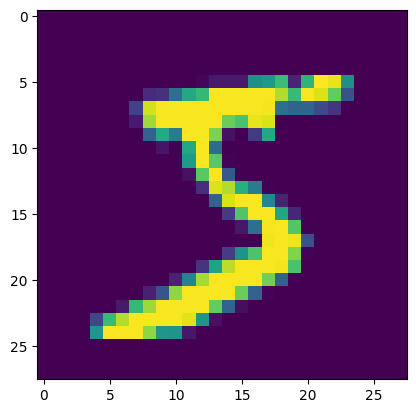

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Previously, we used 2D tensor in Seminar 2.1 and 2.2.

In [ ]:
X_train = X_train.reshape([-1, 28 * 28]) # from 3D to 2D
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
X_train.shape

torch.Size([60000, 784])

# Step 1. Neural network architecture

1. We get scores with Softmax we add probability
2. Loss function is Cross Entropy (**we move SM to inference**)

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100)
mnist_net.to(device)
print(list(mnist_net.parameters()))

[Parameter containing:
tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
        [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
        [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
        ...,
        [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
        [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
        [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
        -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
        -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
         2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
         2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
         2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
         2.3455e-02, -2.5294e-02,  4.8

# Step 2. Optimizer

In [ ]:
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)

# Step 3. Loss Function

In [ ]:
loss = torch.nn.CrossEntropyLoss()

# Step 4. Train Loop

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(3000):
    order = np.random.permutation(len(X_train)) # schedule of batches (случайная растановка элементов - индексы из ордера)

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index: start_index + batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        pred = mnist_net.forward(X_batch) # scores with [100, 10]

        loss_value = loss(pred, y_batch)
        loss_value.backward()

        optimizer.step()

    test_pred = mnist_net.forward(X_test) # [10000, 10]
    loss_value = loss(test_pred, y_test)
    test_loss_history.append(loss_value.to('cpu').detach().numpy())
    accuracy_value = (test_pred.argmax(dim=1) == y_test).float().mean() # if i-th element is equal to
    test_accuracy_history.append(accuracy_value.to('cpu'))
    print(accuracy_value)

tensor(0.9552, device='cuda:0')
tensor(0.9578, device='cuda:0')
tensor(0.9596, device='cuda:0')
tensor(0.9628, device='cuda:0')
tensor(0.9592, device='cuda:0')
tensor(0.9611, device='cuda:0')
tensor(0.9604, device='cuda:0')
tensor(0.9617, device='cuda:0')
tensor(0.9589, device='cuda:0')
tensor(0.9575, device='cuda:0')
tensor(0.9578, device='cuda:0')
tensor(0.9588, device='cuda:0')
tensor(0.9612, device='cuda:0')
tensor(0.9604, device='cuda:0')
tensor(0.9583, device='cuda:0')
tensor(0.9598, device='cuda:0')
tensor(0.9595, device='cuda:0')
tensor(0.9574, device='cuda:0')
tensor(0.9588, device='cuda:0')
tensor(0.9582, device='cuda:0')
tensor(0.9593, device='cuda:0')
tensor(0.9626, device='cuda:0')
tensor(0.9610, device='cuda:0')
tensor(0.9608, device='cuda:0')
tensor(0.9613, device='cuda:0')


KeyboardInterrupt: ignored

**From CPU to GPU**

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri Sep 29 04:27:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   1337MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

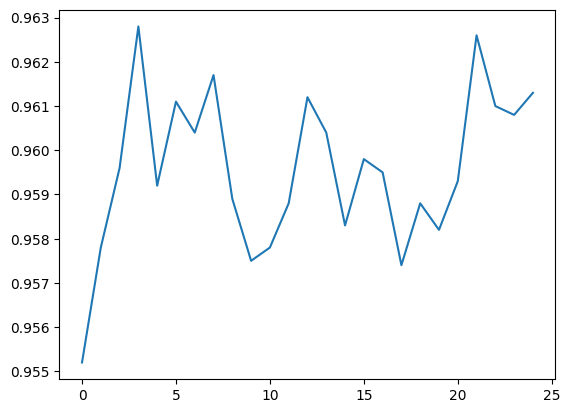

In [ ]:
plt.plot(test_accuracy_history)

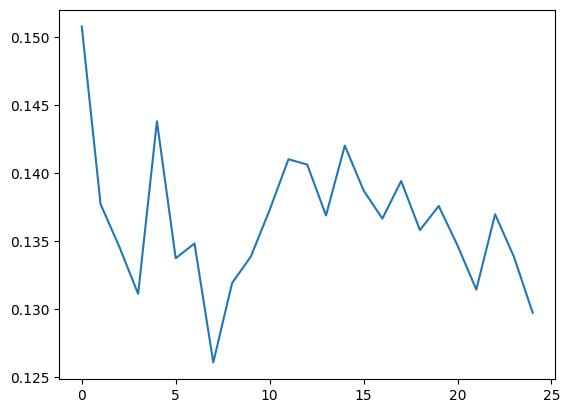

In [ ]:
plt.plot(test_loss_history)